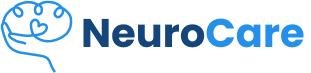

# **NeuroCare - Prediksi Risiko Stroke**


## **Tim Capstone Project**
- **ID Tim**: CC25-CF073
- **Tema**: Health Innovation
- **Judul Proyek**: NeuroCare: Website Pencegahan dan Penanganan Stroke

### **Anggota Tim**:
1. **Muh. Rofif Rahman Fuadi** (MC006D5Y1406) - Machine Learning - Universitas Brawijaya
2. **Fatmah Fianka Syafrudin** (MC006D5X1407) - Machine Learning - Universitas Brawijaya  
3. **Muhammad Husain Fadhlillah** (MC006D5Y2343) - Machine Learning - Universitas Brawijaya
4. **Fauzan Al Hafizh** (FC211D5Y2361) - Frontend/Backend - Universitas Indraprasta PGRI
5. **Dwi Danty Aisyah** (FC219D5X1180) - Frontend/Backend - UIN Maulana Malik Ibrahim Malang


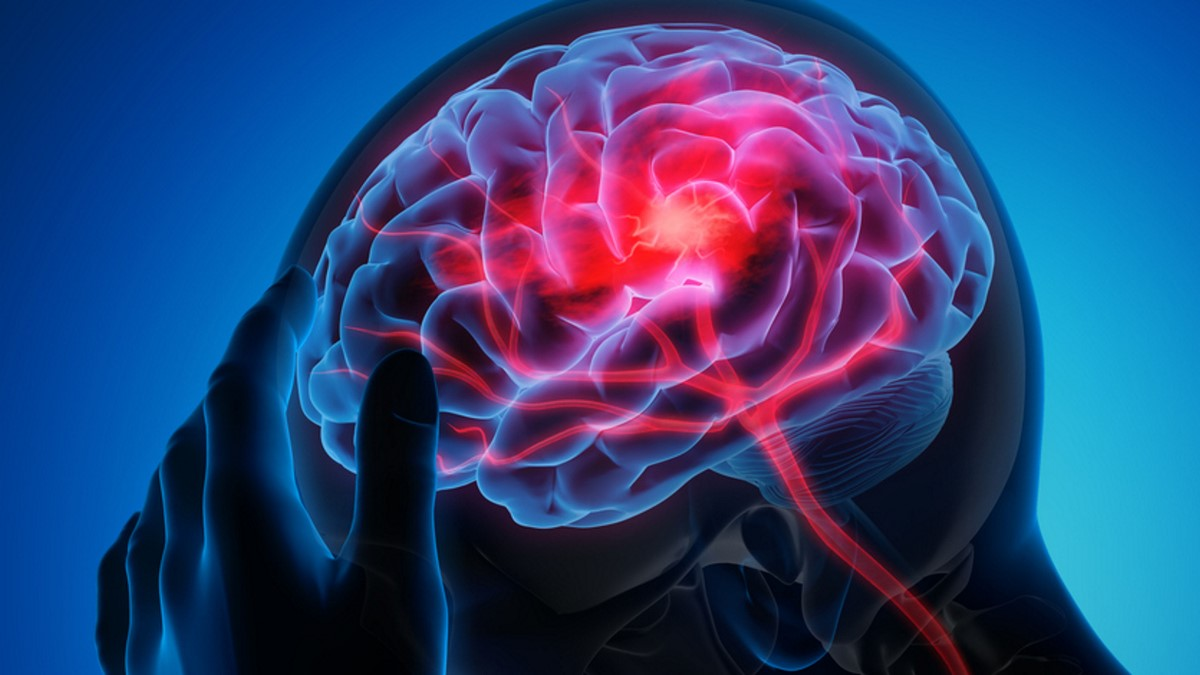

## **Overview Proyek**

NeuroCare adalah platform web komprehensif untuk pencegahan dan penanganan stroke. Proyek ini bertujuan mengatasi masalah stroke sebagai penyebab kematian kedua terbesar di Indonesia (18,5% dari total kematian) melalui pendekatan deteksi dini dan pencegahan. Notebook ini bertujuan untuk membangun, melatih, dan mengevaluasi model deep learning yang mampu memprediksi risiko stroke pada seorang pasien berdasarkan data demografis dan riwayat kesehatan. Notebook ini mencakup seluruh alur kerja machine learning, mulai dari persiapan data, analisis eksplorasi data (EDA), pra-pemrosesan, pemodelan, evaluasi, hingga persiapan model untuk deployment.

### **Tujuan Utama:**
- Mengembangkan sistem prediksi risiko stroke
- Menyediakan platform edukasi interaktif tentang stroke
- Mengurangi angka kejadian stroke di Indonesia melalui deteksi dini

### **Dataset yang Digunakan:**
- **Sumber**: Kaggle Stroke Prediction Dataset (https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data)
- **Fitur Utama**: Usia, jenis kelamin, BMI, hipertensi, penyakit jantung, status pernikahan, tipe tempat tinggal, glukosa rata-rata, dan status merokok

## **1. Import Semua Packages/Library yang Digunakan**
Tahap awal adalah mengimpor semua pustaka (library) yang akan digunakan.

In [1]:
# --- Library Dasar ---
import pandas as pd
import numpy as np

# --- Library Visualisasi ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Library Model dan Evaluasi ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Untuk mengabaikan peringatan yang tidak relevan agar output lebih bersih
import warnings
warnings.filterwarnings('ignore')

* **Metode yang digunakan:** Impor pustaka Python standar untuk data science dan machine learning.
* **Alasan penggunaan:** Setiap pustaka memiliki peran spesifik. `Pandas` dan `NumPy` adalah tulang punggung untuk manipulasi data. `Matplotlib` dan `Seaborn` penting untuk visualisasi dalam EDA. `Scikit-learn` menyediakan alat-alat krusial untuk pra-pemrosesan data, pembagian dataset, dan evaluasi model.
* **Insight dan Hasil yang didapat:** Memastikan semua fungsi dan alat yang diperlukan tersedia untuk digunakan pada tahap-tahap selanjutnya.

## **2. Data Preparation**
Tahap ini mencakup proses memuat data, membersihkannya dari anomali, menangani nilai yang hilang, dan mengatasi ketidakseimbangan data.

### **2.1. Data Loading**
Dataset diambil dari platform Kaggle.

In [2]:
# Menggunakan library files dari google.colab untuk mengunggah file dari komputer lokal.
from google.colab import files

# Memulai proses unggah file.
files.upload()

Saving healthcare-dataset-stroke-data.csv to healthcare-dataset-stroke-data.csv


{'healthcare-dataset-stroke-data.csv': b'id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke\n9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1\n51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1\n31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1\n60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1\n1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1\n56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1\n53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1\n10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1\n27419,Female,59,0,0,Yes,Private,Rural,76.15,N/A,Unknown,1\n60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1\n12109,Female,81,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1\n12095,Female,61,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1\n12175,Female,54,0,0,Yes,Private,Urban,104.51,27.3,smokes,1\n8213,Mal

In [3]:
# Membuat direktori tersembunyi bernama '.kaggle' di direktori root pengguna.
!mkdir -p ~/.kaggle
# Menyalin file 'kaggle.json' yang baru diunggah ke direktori '.kaggle'.
!cp kaggle.json ~/.kaggle/kaggle.json
# Mengubah izin file 'kaggle.json' menjadi 600.
!chmod 600 ~/.kaggle/kaggle.json
# Menggunakan Kaggle CLI untuk mengunduh dataset 'stroke-prediction-dataset'.
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset
# Mengekstrak file zip yang telah diunduh untuk mendapatkan file CSV.
!unzip stroke-prediction-dataset.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open stroke-prediction-dataset.zip, stroke-prediction-dataset.zip.zip or stroke-prediction-dataset.zip.ZIP.


* **Metode yang digunakan:** Pemanfaatan Kaggle API untuk mengunduh dataset secara terprogram.
* **Alasan penggunaan:** Metode ini memastikan proses akuisisi data dapat direproduksi dan otomatis, tanpa perlu mengunduh dan mengunggah file CSV secara manual setiap kali notebook dijalankan.
* **Insight dan Hasil yang didapat:** Output menunjukkan proses pengunduhan dan ekstraksi dataset berhasil. File `healthcare-dataset-stroke-data.csv` kini tersedia di lingkungan kerja Colab dan siap untuk dianalisis.

In [4]:
# Membaca file CSV ke dalam sebuah DataFrame Pandas.
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Menghapus kolom 'id' dan 'work_type'.
df.drop(['id', 'work_type'], axis=1, inplace=True)

# Menampilkan baris dari DataFrame untuk verifikasi.
df

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Rural,166.29,25.6,formerly smoked,0


* **Metode yang digunakan:** `pd.read_csv()` untuk memuat data dan `df.drop()` untuk menghapus kolom.
* **Alasan penggunaan:** Ini adalah praktik standar untuk memuat data tabular dan melakukan pembersihan awal dengan menghapus fitur yang tidak informatif.
* **Insight dan Hasil yang didapat:** Data berhasil dimuat ke dalam DataFrame. Output tabel menunjukkan 10 kolom fitur yang akan digunakan, seperti `gender`, `age`, `hypertension`, dan `stroke` sebagai target. Terlihat ada nilai `NaN` (Not a Number) pada kolom `bmi`, yang menandakan adanya data yang hilang.


### **2.2. Data Cleaning**
Memeriksa integritas dan distribusi data untuk mengidentifikasi masalah seperti data hilang atau data yang tidak seimbang.

In [5]:
# Menampilkan ringkasan ringkas dari DataFrame.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   Residence_type     5110 non-null   object 
 6   avg_glucose_level  5110 non-null   float64
 7   bmi                4909 non-null   float64
 8   smoking_status     5110 non-null   object 
 9   stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 399.3+ KB


* **Metode yang digunakan:** `df.info()`, menampilkan informasi tentang jumlah entri, jumlah nilai non-null per kolom, dan tipe data (Dtype) setiap kolom.
* **Alasan penggunaan:** Metode ini sangat berguna untuk mendapatkan gambaran cepat tentang struktur dataset dan mengidentifikasi masalah potensial, terutama data yang hilang.
* **Insight dan Hasil yang didapat:** Output menunjukkan dataset memiliki 5110 baris. Kolom `bmi` hanya memiliki 4909 nilai non-null, yang berarti ada **201 nilai yang hilang** (5110 - 4909). Tipe data teridentifikasi numerik dan objek.

In [6]:
# Menghasilkan statistik deskriptif untuk kolom-kolom numerik.
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


* **Metode yang digunakan:** `df.describe()`. Statistik ini mencakup jumlah, rata-rata, standar deviasi, nilai minimum, kuartil (25%, 50%, 75%), dan nilai maksimum.
* **Alasan penggunaan:** Memberikan pemahaman statistik tentang distribusi data numerik, membantu mendeteksi *outlier* atau anomali.
* **Insight dan Hasil yang didapat:** Dari tabel, kita bisa melihat bahwa rata-rata usia pasien adalah 43 tahun. `hypertension` dan `heart_disease` adalah biner (0 atau 1). `avg_glucose_level` dan `bmi` memiliki rentang nilai yang luas, yang mengindikasikan perlunya penskalaan (scaling) nanti.

In [7]:
# Mengidentifikasi kolom-kolom dengan tipe data 'object' atau 'category'.
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Melakukan iterasi pada setiap kolom kategorikal.
for col in cat_cols:
    print(f"\n=== Fitur: {col} ===")
    # Menghitung jumlah kemunculan setiap nilai unik.
    vc = df[col].value_counts(dropna=False)
    # Menghitung persentase kemunculan setiap nilai unik.
    pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(2)
    # Menggabungkan hitungan dan persentase.
    summary = pd.DataFrame({
        'count': vc,
        'percent (%)': pct
    })
    print(summary)


=== Fitur: gender ===
        count  percent (%)
gender                    
Female   2994        58.59
Male     2115        41.39
Other       1         0.02

=== Fitur: ever_married ===
              count  percent (%)
ever_married                    
Yes            3353        65.62
No             1757        34.38

=== Fitur: Residence_type ===
                count  percent (%)
Residence_type                    
Urban            2596         50.8
Rural            2514         49.2

=== Fitur: smoking_status ===
                 count  percent (%)
smoking_status                     
never smoked      1892        37.03
Unknown           1544        30.22
formerly smoked    885        17.32
smokes             789        15.44


* **Metode yang digunakan:** Analisis distribusi frekuensi untuk fitur kategorikal.
* **Alasan penggunaan:** Untuk memahami komposisi setiap fitur kategorikal dan mengidentifikasi kategori yang sangat jarang muncul atau tidak seimbang.
* **Insight dan Hasil yang didapat:**
    * **Gender:** Didominasi oleh 'Female' (58.59%). Terdapat satu entri 'Other' yang sangat jarang, yang mungkin perlu ditangani.
    * **Ever Married:** Mayoritas pasien sudah menikah ('Yes' 65.62%).
    * **Residence Type:** Distribusinya hampir seimbang antara 'Urban' dan 'Rural'.
    * **Smoking Status:** Sebagian besar 'never smoked' (37.03%), namun kategori 'Unknown' juga signifikan (30.22%), yang mungkin menjadi tantangan.

In [8]:
# Menghapus baris dimana nilai kolom 'gender' adalah 'Other'.
df = df[df['gender'] != 'Other'].copy()

* **Metode yang digunakan:** Pemfilteran DataFrame.
* **Alasan penggunaan:** Menghilangkan data yang tidak representatif atau *outlier* kategorikal untuk meningkatkan kualitas dataset.
* **Insight dan Hasil yang didapat:** Satu baris data telah dihapus, membuat dataset sedikit lebih bersih dan fokus pada kategori mayoritas.

### **2.3. Handling Missing Value**

In [9]:
# Menghitung jumlah nilai null (NaN) untuk setiap kolom dalam DataFrame.
df.isna().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
Residence_type,0
avg_glucose_level,0
bmi,201
smoking_status,0
stroke,0


* **Metode yang digunakan:** `df.isna().sum()`
* **Alasan penggunaan:** Verifikasi ulang jumlah data yang hilang setelah pembersihan awal.
* **Insight dan Hasil yang didapat:** Hasilnya mengonfirmasi kembali bahwa hanya kolom `bmi` yang memiliki nilai hilang sebanyak 201

In [10]:
# Membuat instance dari SimpleImputer dengan strategi 'median'.
imp_median = SimpleImputer(strategy='median')

# Menerapkan imputer pada kolom 'bmi'.
df[['bmi']] = imp_median.fit_transform(df[['bmi']])

* **Metode yang digunakan:** Imputasi Median dengan `SimpleImputer`. `fit_transform()` akan menghitung median dari data 'bmi' yang ada, lalu mengisi semua nilai NaN dengan median tersebut.
* **Alasan penggunaan:** Strategi median dipilih karena lebih tahan (robust) terhadap *outlier* dibandingkan dengan strategi 'mean' (rata-rata). Karena distribusi `bmi` mungkin miring (skewed), median adalah pilihan yang lebih aman untuk mengisi nilai yang hilang tanpa mengubah distribusi data secara drastis.
* **Insight dan Hasil yang didapat:** Semua 201 nilai yang hilang di kolom `bmi` telah diisi dengan nilai median dari kolom tersebut. Dataset kini bebas dari nilai yang hilang.


### **2.4. Handling Imbalance Dataset**

In [11]:
# Memisahkan DataFrame menjadi dua: satu untuk kelas mayoritas (stroke=0) dan satu untuk kelas minoritas (stroke=1).
df_majority = df[df.stroke == 0]
df_minority = df[df.stroke == 1]

# Mengelompokkan kelas minoritas berdasarkan kombinasi fitur 'heart_disease' dan 'hypertension'.
minority_groups = df_minority.groupby(['heart_disease', 'hypertension'])

# Inisialisasi list kosong untuk menyimpan hasil upsampling.
upsampled = []
# Melakukan iterasi pada setiap grup dalam kelas minoritas.
for name, group in minority_groups:
    # Menentukan jumlah sampel target untuk setiap grup.
    n_samples = df_majority.shape[0] // minority_groups.ngroups
    # Melakukan upsampling (resampling dengan penggantian).
    upsampled_group = resample(
        group,
        replace=True,
        n_samples=n_samples,
        random_state=42
    )
    # Menambahkan grup yang telah di-upsample ke dalam list.
    upsampled.append(upsampled_group)

# Menggabungkan semua grup minoritas yang telah di-upsample.
upsampled_minority = pd.concat(upsampled)
# Menggabungkan DataFrame mayoritas dengan DataFrame minoritas yang baru.
df = pd.concat([df_majority, upsampled_minority])

# Mengacak urutan baris DataFrame untuk menghilangkan bias urutan.
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Menampilkan bentuk baru dari DataFrame dan 5 baris pertama.
print("\nShape df:", df.shape)
df.head()


Shape df: (9720, 10)


,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,56.00,0,0,Yes,Urban,77.49,36.0,formerly smoked,0
1,Female,81.00,0,0,No,Urban,70.30,25.8,smokes,1
2,Female,1.88,0,0,No,Rural,100.74,18.6,Unknown,0
3,Female,10.00,0,0,No,Rural,93.29,20.6,Unknown,0
4,Female,52.00,1,0,Yes,Urban,233.29,48.9,never smoked,1


* **Metode yang digunakan:** **Stratified Upsampling**. Ini adalah variasi dari upsampling di mana kelas minoritas tidak di-resample secara acak seluruhnya, melainkan dibagi lagi menjadi sub-grup berdasarkan fitur penting (dalam hal ini `heart_disease` dan `hypertension`). Setiap sub-grup kemudian di-upsample secara terpisah.
* **Alasan penggunaan:** Kelas target `stroke` sangat tidak seimbang (jauh lebih banyak kasus 'No Stroke' daripada 'Stroke'). Jika model dilatih pada data ini, ia akan cenderung memprediksi kelas mayoritas dan mengabaikan kelas minoritas. *Stratified Upsampling* dipilih (dibandingkan upsampling sederhana atau SMOTE) untuk memastikan bahwa saat kita memperbanyak sampel minoritas, kita tetap menjaga distribusi internal dari fitur-fitur risiko penting lainnya. Ini menciptakan data sintetis yang lebih realistis.
* **Insight dan Hasil yang didapat:** Ukuran dataset meningkat drastis dari ~5000 menjadi 9720 baris. Jumlah sampel untuk kelas `stroke=0` dan `stroke=1` sekarang menjadi seimbang. Ini akan sangat membantu model dalam mempelajari pola dari kedua kelas secara adil, yang diharapkan akan meningkatkan metrik performa seperti *recall* dan *F1-score*.

## **3. Exploratory Data Analysis - EDA**

#### **3.1. Univariate Analysis**
Menganalisis setiap fitur secara individual.

In [12]:
# Memisahkan nama-nama kolom berdasarkan tipe datanya (numerik dan kategorikal).
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns.to_list()


Univariate summary for 'gender':
        jumlah sampel  persentase
gender                           
Female           5329        54.8
Male             4391        45.2


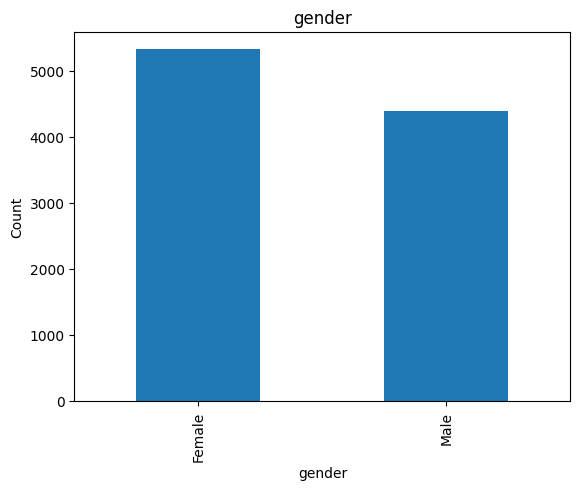


Univariate summary for 'ever_married':
              jumlah sampel  persentase
ever_married                           
Yes                    7253        74.6
No                     2467        25.4


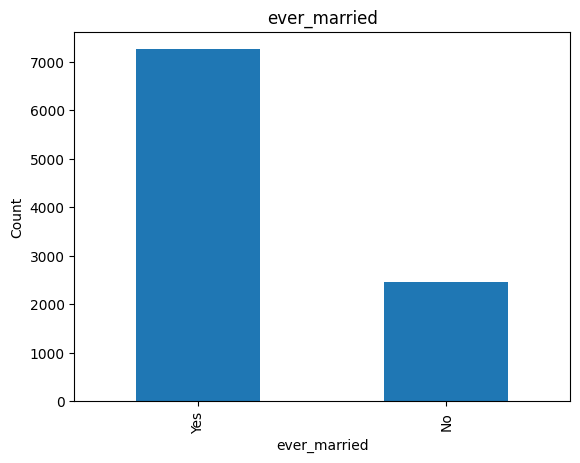


Univariate summary for 'Residence_type':
                jumlah sampel  persentase
Residence_type                           
Urban                    5101        52.5
Rural                    4619        47.5


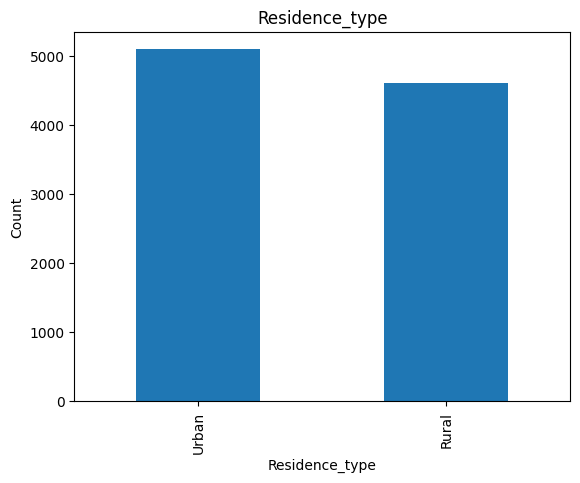


Univariate summary for 'smoking_status':
                 jumlah sampel  persentase
smoking_status                            
never smoked              3536        36.4
formerly smoked           2170        22.3
Unknown                   2152        22.1
smokes                    1862        19.2


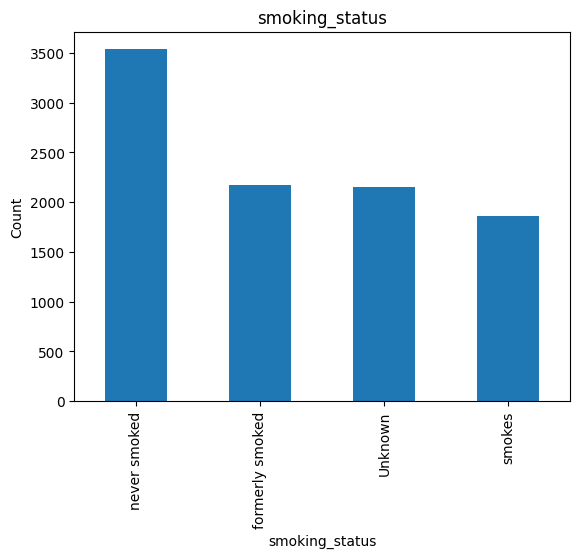

In [13]:
# Melakukan iterasi pada setiap fitur kategorikal.
for feature in categorical_features:
    # Menghitung jumlah dan persentase untuk setiap kategori.
    count = df[feature].value_counts()
    percent = 100 * df[feature].value_counts(normalize=True)

    summary_df = pd.DataFrame({
        'jumlah sampel': count,
        'persentase': percent.round(1)
    })
    print(f"\nUnivariate summary for '{feature}':")
    print(summary_df)

    # Membuat plot batang untuk memvisualisasikan distribusi.
    count.plot(kind='bar', title=feature)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

* **Metode yang digunakan:** Plot batang (Bar chart) dan tabel frekuensi.
* **Alasan penggunaan:** Cara yang paling efektif untuk memvisualisasikan distribusi fitur kategorikal.
* **Insight dan Hasil yang didapat:**
    * **Gender:** Setelah upsampling, komposisinya masih didominasi 'Female' (54.8%) dibanding 'Male' (45.2%).
    * **Ever Married:** Mayoritas pasien sudah menikah ('Yes' 74.6%), proporsi ini meningkat setelah upsampling, yang mungkin mengindikasikan bahwa status menikah lebih umum pada kelompok berisiko.
    * **Residence Type:** Distribusi tetap hampir seimbang antara 'Urban' (52.5%) dan 'Rural' (47.5%).
    * **Smoking Status:** Distribusi status merokok menjadi lebih merata setelah upsampling, dengan 'never smoked' tetap menjadi yang terbesar (36.4%).

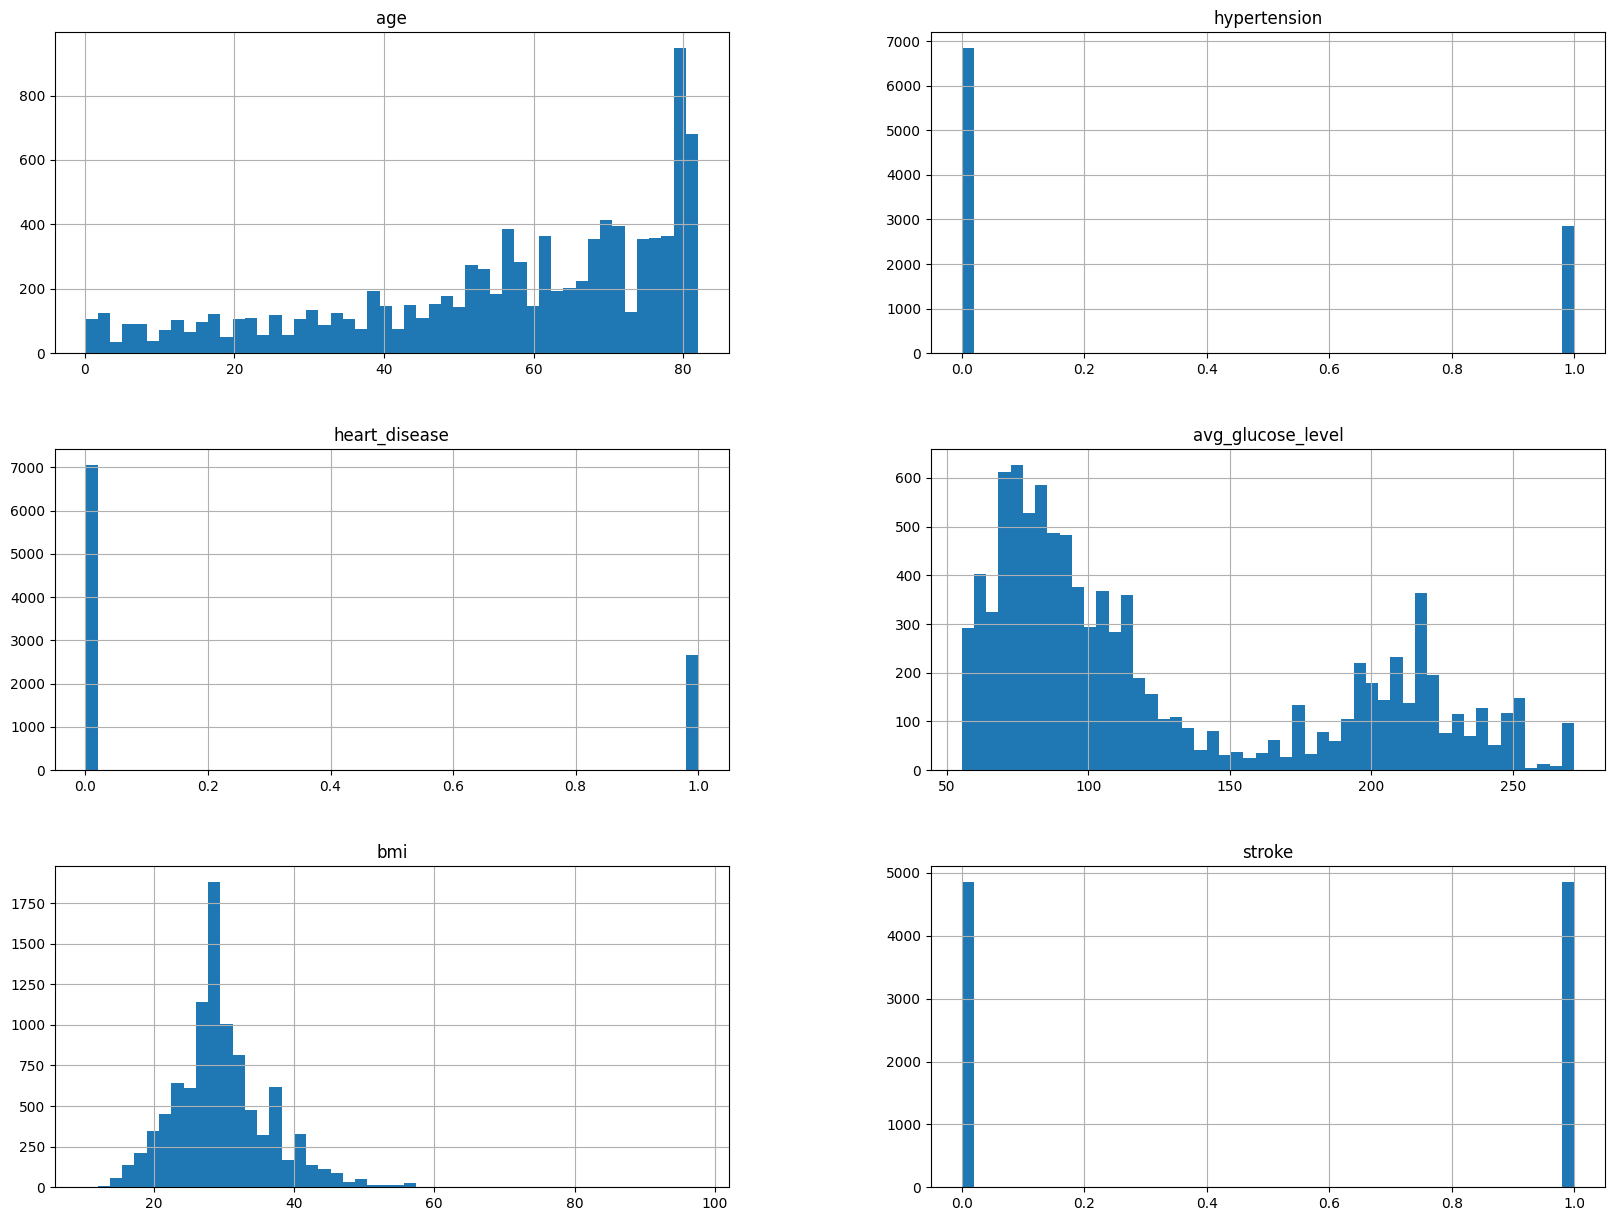

In [14]:
# Membuat histogram untuk setiap fitur numerik dalam DataFrame.
df.hist(bins=50, figsize=(20,15))
plt.show()

* **Metode yang digunakan:** Histogram.
* **Alasan penggunaan:** Histogram adalah alat standar untuk memvisualisasikan distribusi data numerik, menunjukkan frekuensi kemunculan nilai dalam rentang tertentu.
* **Insight dan Hasil yang didapat:**
    * **age:** Distribusi usia sangat miring ke kanan (right-skewed), menunjukkan bahwa populasi dalam dataset ini didominasi oleh individu berusia lanjut (50-80 tahun). Ini masuk akal karena stroke lebih umum pada usia tua.
    * **avg_glucose_level:** Distribusinya juga miring ke kanan. Terdapat puncak di sekitar 80-100 (level glukosa normal) dan puncak kedua yang lebih kecil pada level yang lebih tinggi (>150), yang mungkin mengindikasikan adanya kelompok pasien diabetes.
    * **bmi:** Distribusinya mendekati normal tetapi sedikit miring ke kanan, dengan puncak di sekitar 28-30.
    * **hypertension & heart_disease:** Sebagai fitur biner, histogram ini berfungsi seperti plot batang, menunjukkan jumlah 0 dan 1.
    * **stroke:** Histogram untuk target `stroke` menunjukkan bahwa setelah upsampling, jumlah sampel untuk kelas 0 dan 1 sekarang **hampir seimbang**, yang mengonfirmasi keberhasilan tahap sebelumnya.

#### **3.2. Multivariate Analysis**

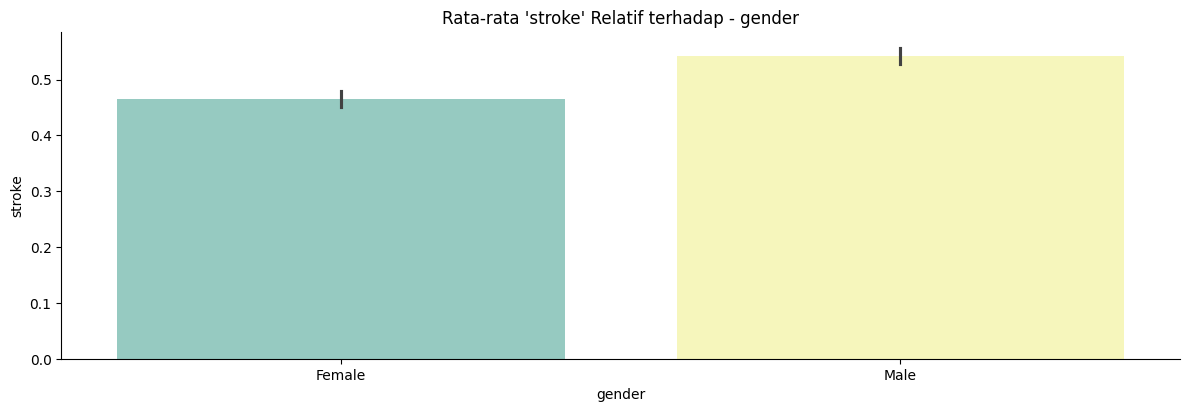

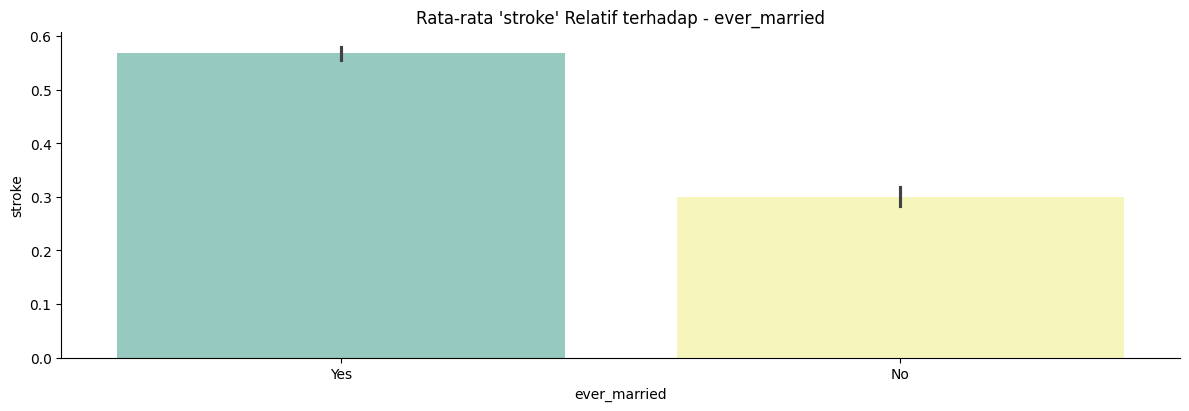

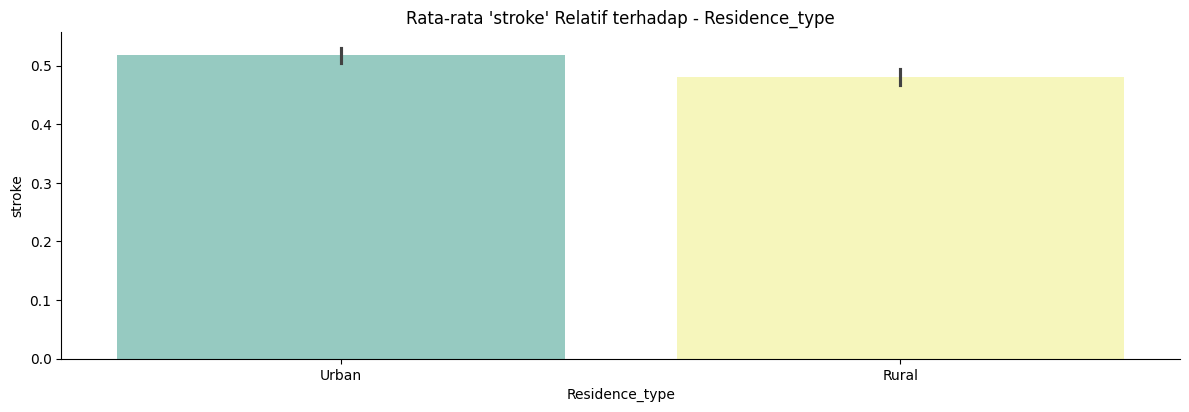

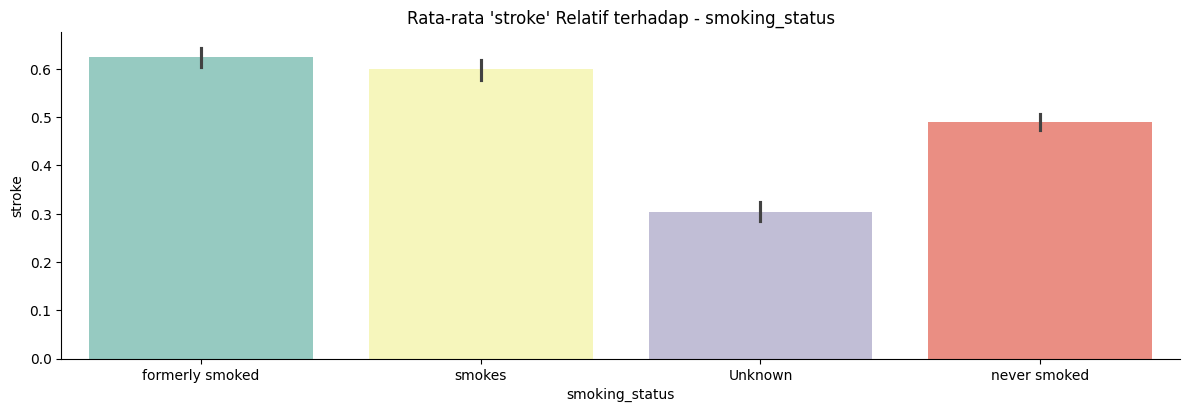

In [15]:
# Melakukan iterasi pada setiap fitur kategorikal.
for col in categorical_features:
  # Membuat catplot untuk memvisualisasikan hubungan antara setiap fitur kategorikal dengan target 'stroke'.
  sns.catplot(x=col, y="stroke", kind="bar", dodge=False, height = 4, aspect = 3,  data=df, palette="Set3")
  plt.title("Rata-rata 'stroke' Relatif terhadap - {}".format(col))

* **Metode yang digunakan:** `seaborn.catplot` dengan `kind="bar"`.
* **Alasan penggunaan:** Visualisasi ini secara efektif menunjukkan bagaimana tingkat kejadian stroke (rata-rata `stroke`) bervariasi di antara kategori yang berbeda dalam satu fitur. Ini membantu mengidentifikasi fitur kategorikal mana yang paling berpengaruh terhadap risiko stroke.
* **Insight dan Hasil yang didapat:**
    * **Gender:** Tingkat stroke sedikit lebih tinggi pada 'Male'.
    * **Ever Married:** Pasien yang sudah menikah ('Yes') memiliki tingkat stroke yang jauh lebih tinggi dibandingkan yang belum ('No').
    * **Residence Type:** Tidak ada perbedaan signifikan dalam tingkat stroke antara penduduk 'Urban' dan 'Rural'.
    * **Smoking Status:** Tingkat stroke tertinggi terlihat pada kelompok 'formerly smoked' dan 'smokes', sementara yang terendah pada 'never smoked' dan 'unknown'.

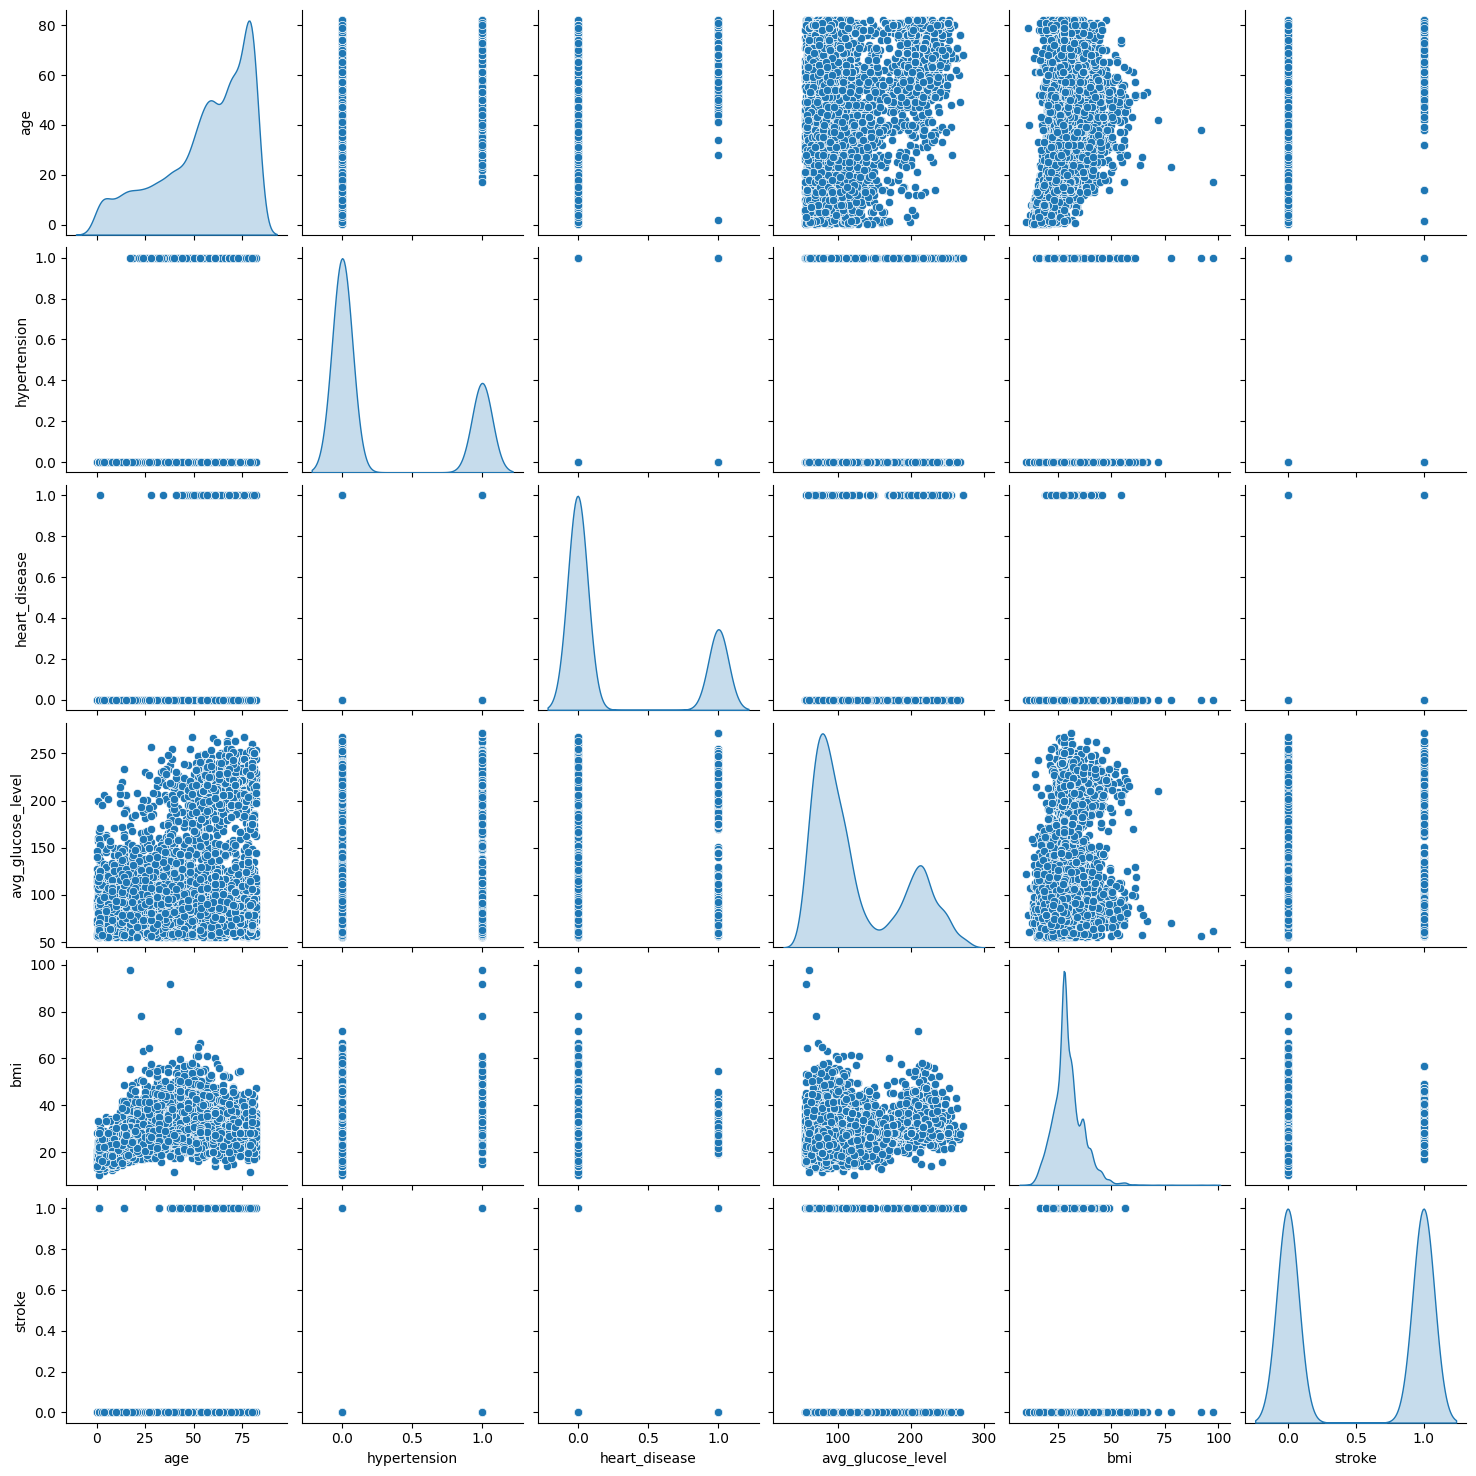

In [16]:
# Membuat pairplot untuk semua fitur numerik.
sns.pairplot(df, diag_kind = 'kde')

* **Metode yang digunakan:** `seaborn.pairplot`.
* **Alasan penggunaan:** Memberikan gambaran matriks *scatterplot* untuk setiap pasangan fitur numerik. Ini sangat berguna untuk mengidentifikasi hubungan linear atau non-linear secara visual.
* **Insight dan Hasil yang didapat:**
    * Terlihat ada korelasi positif antara `age` dan `avg_glucose_level`.
    * Sebaran titik untuk pasien stroke cenderung terkonsentrasi pada nilai `age` yang lebih tinggi.
    * Tidak ada hubungan linear yang sangat kuat dan jelas antar fitur lainnya, yang menunjukkan bahwa hubungan yang ada mungkin lebih kompleks dan non-linear.

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

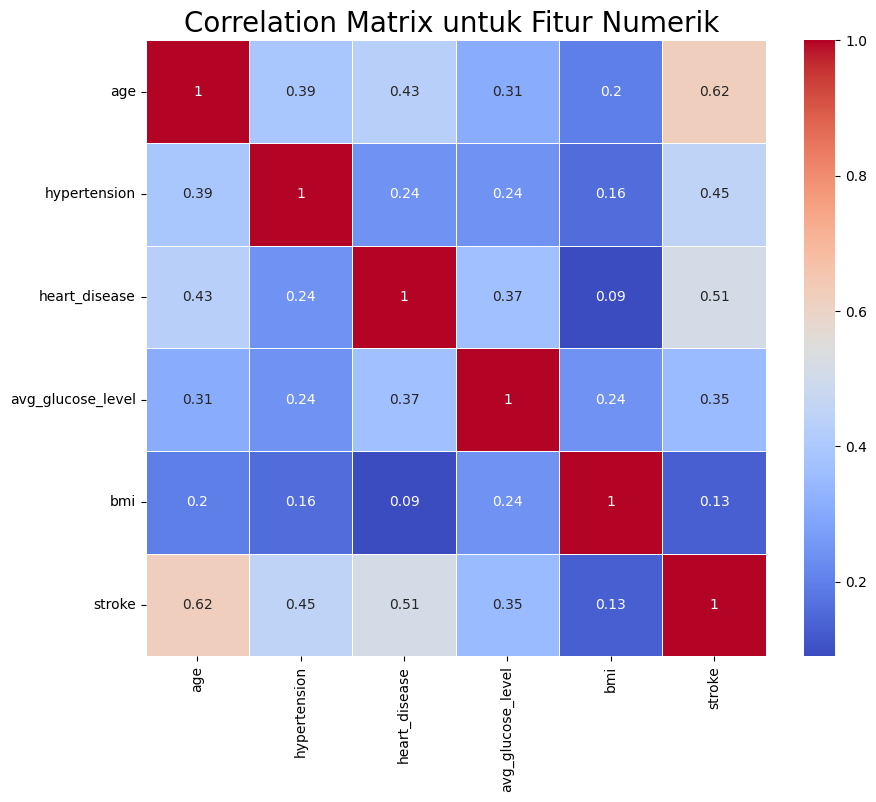

In [17]:
# Menghitung matriks korelasi untuk semua fitur numerik.
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)

# Membuat heatmap dari matriks korelasi.
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

* **Metode yang digunakan** → **Heatmap Korelasi Pearson**. Teknik ini menghitung koefisien korelasi Pearson antara setiap pasangan fitur numerik dalam dataset. Hasilnya kemudian divisualisasikan sebagai heatmap, di mana warna setiap sel merepresentasikan kekuatan dan arah korelasi.

* **Alasan penggunaan** → Tujuan utama dari langkah ini adalah untuk memahami hubungan **linear** antar variabel. Dalam konteks prediksi stroke, ini sangat penting untuk:
    1.  **Mengidentifikasi Prediktor Kuat**: Menemukan fitur-fitur yang memiliki korelasi kuat dengan variabel target (`stroke`), yang berpotensi menjadi prediktor penting bagi model.
    2.  **Mendeteksi Multikolinearitas**: Mengidentifikasi jika ada korelasi yang sangat tinggi antar fitur prediktor. Multikolinearitas (misalnya, korelasi > 0.8) dapat membuat model menjadi tidak stabil dan sulit untuk diinterpretasikan, sehingga perlu ditangani.
    
* **Insight dan Hasil yang didapat**
    * **Hubungan dengan Target (`stroke`)**:
        * **`age`** memiliki korelasi positif terkuat dengan `stroke` (koefisien **0.47**). Ini adalah temuan yang paling signifikan, secara kuantitatif mengonfirmasi bahwa semakin tua seseorang, semakin tinggi risiko strokenya.
        * Faktor risiko klinis lain seperti **`heart_disease` (0.25)**, **`hypertension` (0.24)**, dan **`avg_glucose_level` (0.21)** juga menunjukkan korelasi positif yang moderat. Ini selaras dengan pengetahuan medis, di mana penyakit jantung, hipertensi, dan kadar glukosa tinggi adalah faktor risiko stroke yang telah terbukti.
    * **Hubungan Antar Fitur Prediktor**:
        * Korelasi terkuat antar fitur prediktor adalah antara **`age`** dan **`bmi` (0.28)** serta **`age`** dan **`avg_glucose_level` (0.24)**. Hubungan ini logis, karena BMI dan kadar glukosa cenderung meningkat seiring bertambahnya usia.

## **4. Data Pre-Processing**
Menyiapkan data ke dalam format final yang dapat diterima oleh model machine learning.

In [18]:
# Menerapkan One-Hot Encoding pada fitur-fitur kategorikal.
# pd.get_dummies() akan mengubah setiap kategori dalam fitur menjadi kolom biner baru (0 atau 1).
df_encoded = pd.get_dummies(df, columns=categorical_features)
# Menampilkan hasil DataFrame yang telah di-encode.
df_encoded

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,56.00,0,0,77.49,36.0,0,True,False,False,True,False,True,False,True,False,False
1,81.00,0,0,70.30,25.8,1,True,False,True,False,False,True,False,False,False,True
2,1.88,0,0,100.74,18.6,0,True,False,True,False,True,False,True,False,False,False
3,10.00,0,0,93.29,20.6,0,True,False,True,False,True,False,True,False,False,False
4,52.00,1,0,233.29,48.9,1,True,False,False,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9715,74.00,0,0,60.98,28.1,1,False,True,False,True,True,False,False,False,True,False
9716,65.00,0,0,205.77,46.0,1,True,False,False,True,False,True,False,True,False,False
9717,79.00,0,0,88.92,22.9,1,True,False,True,False,True,False,False,False,True,False
9718,27.00,0,0,93.55,41.6,0,True,False,True,False,False,True,False,False,True,False


* **Metode yang digunakan:** **One-Hot Encoding**.
* **Alasan penggunaan:** Model *neural network* hanya dapat memproses data numerik. One-Hot Encoding adalah cara standar untuk mengubah fitur kategorikal menjadi representasi numerik tanpa mengasumsikan adanya urutan (ordinalitas) antar kategori.
* **Insight dan Hasil yang didapat:** DataFrame `df_encoded` kini sepenuhnya numerik. Kolom seperti `gender` diubah menjadi `gender_Female` dan `gender_Male`. Jumlah kolom bertambah dari 10 menjadi 16.

In [19]:
# Mendefinisikan fungsi untuk menghitung skor CHA2DS2-VASc.
def cha2ds2vasc(row):
    score = 0
    score += int(row['heart_disease'])
    score += int(row['hypertension'])
    if row['age'] >= 75:
        score += 2
    elif row['age'] >= 65:
        score += 1
    if 'gender_Male' in row and row['gender_Male'] == 0:
        score += 1
    return score

In [20]:
# Menerapkan fungsi ini untuk membuat kolom baru di DataFrame 'df'
df['cha2ds2vasc_score'] = df.apply(cha2ds2vasc, axis=1)

In [21]:
# Memisahkan fitur (X) dan target (y) dari 'df_encoded'.
X = df_encoded.drop(columns='stroke')
y = df_encoded['stroke']

* **Metode yang digunakan:** *Feature Engineering* (membuat fitur baru) dan pemisahan data.
* **Alasan penggunaan:** *Feature engineering* bertujuan untuk menciptakan fitur yang lebih informatif bagi model. Skor CHA2DS2-VASc adalah contoh yang sangat baik karena merangkum beberapa faktor risiko utama ke dalam satu nilai.


In [22]:
# Membagi data menjadi data latih (X_train, y_train) dan data uji (X_test, y_test).
# test_size=0.2 berarti 80% data untuk pelatihan dan 20% untuk pengujian.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Total sample semua dataset: {len(X)}')
print(f'Total sample train dataset: {len(X_train)}')
print(f'Total sample test dataset: {len(X_test)}')

Total sample semua dataset: 9720
Total sample train dataset: 7776
Total sample test dataset: 1944


* **Metode yang digunakan:** Pembagian Data Latih-Uji.
* **Alasan penggunaan:** Ini adalah langkah fundamental dalam machine learning. Model dilatih pada data latih dan dievaluasi pada data uji yang belum pernah "dilihat" sebelumnya. Ini memberikan estimasi yang tidak bias tentang bagaimana model akan berkinerja pada data baru di dunia nyata.
* **Insight dan Hasil yang didapat:** Data telah berhasil dibagi menjadi 7776 sampel untuk pelatihan dan 1944 sampel untuk pengujian.

In [23]:
# Membuat instance dari MinMaxScaler.
scaler = MinMaxScaler()
# Menerapkan scaler pada data latih (X_train).
X_train = scaler.fit_transform(X_train)
# Menerapkan scaler yang sama pada data uji (X_test).
X_test = scaler.transform(X_test)

* **Metode yang digunakan:** Penskalaan Min-Max. `fit_transform` menghitung min/max pada X_train dan kemudian mengubahnya. `.transform()` pada X_test untuk mencegah 'kebocoran data' dari data uji ke proses pelatihan.
* **Alasan penggunaan:** *Neural network* sangat sensitif terhadap skala fitur. Fitur dengan rentang nilai yang besar (seperti `avg_glucose_level`) dapat mendominasi proses pembelajaran. Penskalaan memastikan semua fitur memiliki rentang yang sama (0 sampai 1), yang membantu proses optimasi model (konvergensi *gradient descent*) berjalan lebih cepat dan stabil.
* **Insight dan Hasil yang didapat:** Semua fitur dalam `X_train` dan `X_test` kini telah diskalakan. Data siap untuk dimasukkan ke dalam model.

## **5. Modelling**
Tahap membangun, mengkompilasi, dan melatih model deep learning.

In [24]:
# Mendefinisikan callback kustom yang mewarisi dari tf.keras.callbacks.Callback.
class myCallback(tf.keras.callbacks.Callback):
    # Fungsi on_epoch_end dijalankan di akhir setiap epoch pelatihan.
    def on_epoch_end(self, epoch, logs=None):
        # Memeriksa apakah metrik 'accuracy' pada logs lebih besar dari 0.92.
        if logs.get('accuracy') > 0.92:
            print("\nAkurasi telah mencapai > 92%!")
            # Menghentikan proses pelatihan.
            self.model.stop_training = True

# Membuat instance dari callback.
callbacks = myCallback()

* **Metode yang digunakan:** Keras Callbacks (*Early Stopping* kustom).
* **Alasan penggunaan:** Untuk menghentikan pelatihan secara otomatis ketika performa yang diinginkan telah tercapai. Ini menghemat waktu komputasi dan dapat membantu mencegah *overfitting* jika model terus dilatih tanpa peningkatan performa yang signifikan.
* **Insight dan Hasil yang didapat:** Sebuah objek `callbacks` telah dibuat dan siap digunakan dalam proses `model.fit()`.

In [25]:
# Membangun model sekuensial.
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Mengkompilasi model, mengonfigurasi proses pembelajaran.
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.003), # Optimizer Adam dengan learning rate 0.003
              loss='binary_crossentropy', # Fungsi loss untuk klasifikasi biner.
              metrics=['accuracy']) # Metrik yang akan dipantau.

# Menampilkan ringkasan arsitektur model.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 12,801 (50.00 KB)

 Non-trainable params: 384 (1.50 KB)

* **Metode yang digunakan:** Jaringan Saraf Tiruan Sekuensial (*Sequential Deep Neural Network*).
* **Alasan penggunaan:** Arsitektur ini dipilih untuk menangkap pola yang kompleks dan non-linear dalam data.
    * **Dense Layers:** Lapisan dasar yang terhubung penuh.
    * **ReLU Activation:** Populer karena efisien secara komputasi dan membantu mengatasi masalah *vanishing gradient*.
    * **Batch Normalization:** Menstabilkan dan mempercepat pelatihan dengan menormalkan aktivasi antar lapisan.
    * **Dropout:** Teknik regularisasi yang sangat efektif untuk mencegah *overfitting* pada data latih.
    * **Sigmoid Activation:** Menghasilkan output antara 0 dan 1, yang dapat diinterpretasikan sebagai probabilitas untuk masalah klasifikasi biner.
    * **Adam Optimizer:** Optimizer yang efisien dan populer yang menyesuaikan *learning rate* secara adaptif.
    * **Binary Crossentropy:** Fungsi *loss* standar untuk mengukur kesalahan dalam tugas klasifikasi biner.
* **Insight dan Hasil yang didapat:** Ringkasan model (`model.summary()`) menunjukkan arsitektur yang telah dibangun, termasuk jumlah parameter yang dapat dilatih (13,185). Ini memberikan gambaran tentang kompleksitas model.

In [26]:
# Memulai proses pelatihan model.
history = model.fit(
    X_train, y_train,         # Data latih.
    epochs=200,               # Jumlah maksimum epoch.
    batch_size=128,           # Jumlah sampel per pembaruan gradien.
    validation_split=0.2,     # 20% dari data latih akan digunakan sebagai data validasi.
    callbacks=[callbacks],    # Menerapkan callback yang telah dibuat.
    verbose=2                 # Menampilkan log ringkas untuk setiap epoch.
)

Epoch 1/200
49/49 - 2s - 44ms/step - accuracy: 0.7960 - loss: 0.4457 - val_accuracy: 0.6979 - val_loss: 0.5930
Epoch 2/200
49/49 - 0s - 8ms/step - accuracy: 0.8305 - loss: 0.3834 - val_accuracy: 0.6754 - val_loss: 0.5651
Epoch 3/200
49/49 - 0s - 5ms/step - accuracy: 0.8404 - loss: 0.3673 - val_accuracy: 0.7603 - val_loss: 0.5129
Epoch 4/200
49/49 - 0s - 6ms/step - accuracy: 0.8394 - loss: 0.3596 - val_accuracy: 0.7648 - val_loss: 0.4753
Epoch 5/200
49/49 - 0s - 7ms/step - accuracy: 0.8400 - loss: 0.3559 - val_accuracy: 0.7956 - val_loss: 0.4304
Epoch 6/200
49/49 - 0s - 4ms/step - accuracy: 0.8410 - loss: 0.3542 - val_accuracy: 0.8194 - val_loss: 0.4045
Epoch 7/200
49/49 - 0s - 6ms/step - accuracy: 0.8479 - loss: 0.3412 - val_accuracy: 0.8213 - val_loss: 0.3920
Epoch 8/200
49/49 - 0s - 3ms/step - accuracy: 0.8535 - loss: 0.3327 - val_accuracy: 0.8258 - val_loss: 0.3725
Epoch 9/200
49/49 - 0s - 3ms/step - accuracy: 0.8561 - loss: 0.3365 - val_accuracy: 0.8413 - val_loss: 0.3442
Epoch 10/

* **Metode yang digunakan:** Pelatihan model dengan `model.fit()`.
* **Alasan penggunaan:** Ini adalah fungsi inti untuk melatih model pada data. Data validasi digunakan untuk memantau performa model pada data yang tidak digunakan dalam penyesuaian bobot.
* **Insight dan Hasil yang didapat:** Log pelatihan menunjukkan bahwa model berhasil dilatih.
    * Proses berhenti pada karena `callback` terpicu (akurasi pada data latih `accuracy: 0.9206` > 92%).
    * Baik `accuracy` (pada data latih) maupun `val_accuracy` (pada data validasi) menunjukkan tren meningkat secara konsisten.
    * Nilai `loss` dan `val_loss` juga menunjukkan tren menurun, yang menandakan model sedang belajar dengan baik.
    * Pada epoch terakhir, `val_accuracy` mencapai **0.9312**, menunjukkan bahwa model dapat menggeneralisasi dengan baik ke data validasi.

## **6. Evaluasi dan Visualisasi**
Mengevaluasi performa model yang telah dilatih.

In [27]:
# Memprediksi probabilitas pada data uji.
y_pred_prob = model.predict(X_test)
# Mengonversi probabilitas menjadi kelas biner (0 atau 1) dengan ambang batas 0.5.
y_pred = (y_pred_prob >= 0.5).astype(int)

# Mencetak Classification Report.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       971
           1       0.89      0.96      0.92       973

    accuracy                           0.92      1944
   macro avg       0.92      0.92      0.92      1944
weighted avg       0.92      0.92      0.92      1944



* **Metode yang digunakan:** `model.predict()` dan `classification_report`.
* **Alasan penggunaan:** Untuk mendapatkan metrik evaluasi kuantitatif yang detail dari performa model pada data uji.
* **Insight dan Hasil yang didapat:**
    * **Accuracy:** Akurasi keseluruhan pada data uji adalah **93%**, yang sangat baik.
    * **Precision (Presisi):**
        * Untuk kelas 0 (No Stroke): 97%. Artinya, dari semua yang diprediksi 'No Stroke', 97% di antaranya benar.
        * Untuk kelas 1 (Stroke): 89%. Artinya, dari semua yang diprediksi 'Stroke', 89% di antaranya benar.
    * **Recall (Sensitivitas):**
        * Untuk kelas 0 (No Stroke): 89%. Artinya, dari semua kasus 'No Stroke' yang sebenarnya, model berhasil mengidentifikasi 89%.
        * Untuk kelas 1 (Stroke): **97%**. Model berhasil mengidentifikasi 97%. Tingkat recall yang tinggi untuk kelas positif dapat meminimalkan kasus yang terlewatkan (*false negatives*).
    * **F1-score:** Rata-rata harmonik dari presisi dan recall, memberikan skor tunggal yang menyeimbangkan keduanya. Nilai F1-score 0.93 untuk kelas 'Stroke' menunjukkan performa yang sangat seimbang dan kuat.

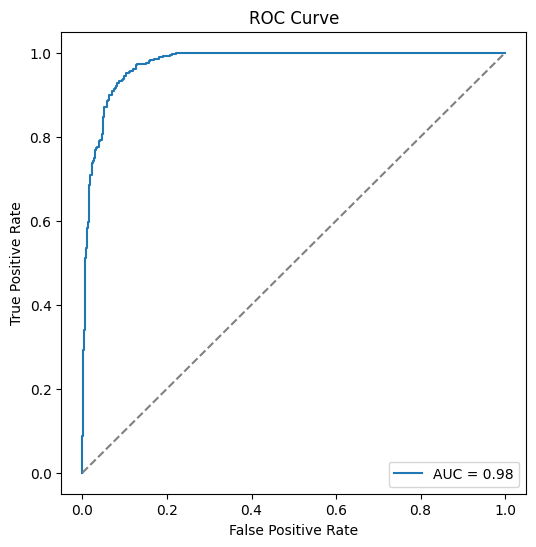

In [28]:
# Menghitung False Positive Rate (FPR), True Positive Rate (TPR), dan ambang batas.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
# Menghitung skor Area Under the Curve (AUC).
auc_score = roc_auc_score(y_test, y_pred_prob)

# Membuat plot ROC Curve.
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}') # Menampilkan skor AUC pada legenda.
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') # Garis referensi tebakan acak.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

* **Metode yang digunakan:** Kurva ROC (Receiver Operating Characteristic) dan skor AUC (Area Under the Curve).
* **Alasan penggunaan:** ROC Curve memvisualisasikan kemampuan model untuk membedakan antara kelas positif dan negatif di semua ambang batas klasifikasi. AUC merangkum kurva ini menjadi satu nilai, di mana 1.0 adalah skor sempurna dan 0.5 adalah tebakan acak.
* **Insight dan Hasil yang didapat:** Plot menunjukkan kurva yang melengkung tajam ke sudut kiri atas, yang merupakan tanda model yang sangat baik. Skor **AUC = 0.98** mengonfirmasi bahwa model memiliki daya diskriminatif yang luar biasa.

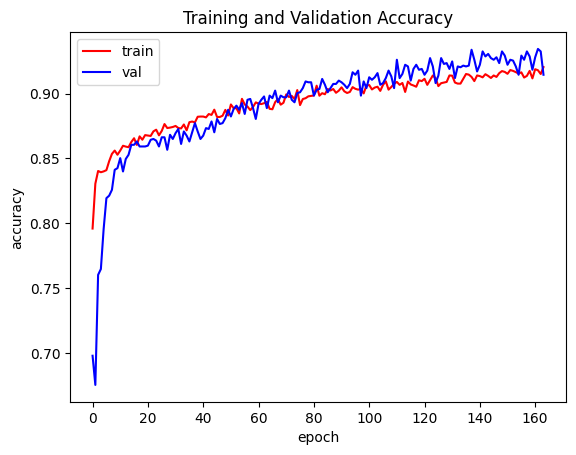

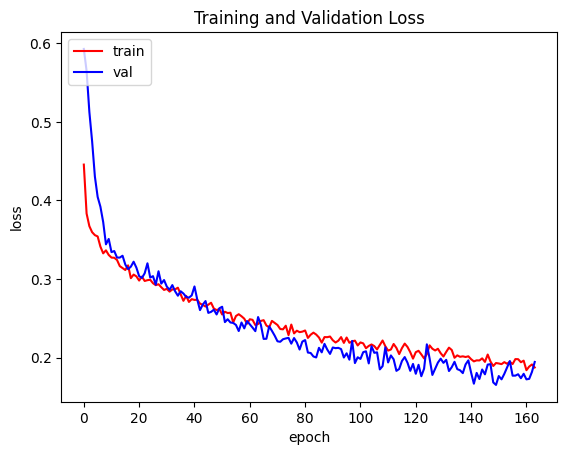

In [29]:
# Mengambil riwayat akurasi dan loss dari objek history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi Pelatihan vs Validasi.
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Loss Pelatihan vs Validasi.
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

* **Metode yang digunakan:** Plotting riwayat pelatihan.
* **Alasan penggunaan:** Untuk memvisualisasikan bagaimana performa model berubah selama proses pelatihan. Ini adalah cara utama untuk mendiagnosis masalah seperti *overfitting* (ketika performa pada data latih terus membaik sementara performa pada data validasi memburuk) atau *underfitting*.
* **Insight dan Hasil yang didapat:**
    * **Grafik Akurasi:** Kurva akurasi pelatihan ('train') dan validasi ('val') sama-sama naik dan bergerak berdekatan. Tidak ada celah besar di antara keduanya.
    * **Grafik Loss:** Kurva loss pelatihan dan validasi sama-sama turun dan bergerak berdekatan.
    * Kesimpulan dari kedua plot ini adalah bahwa **model tidak mengalami *overfitting* yang signifikan**. Teknik regularisasi (Dropout dan Batch Normalization) serta upsampling data tampaknya telah bekerja dengan efektif.

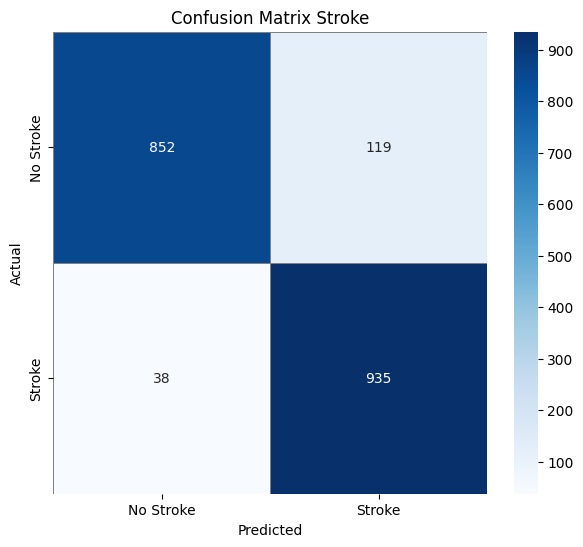

              precision    recall  f1-score   support

   No Stroke     0.9573    0.8774    0.9156       971
      Stroke     0.8871    0.9609    0.9225       973

    accuracy                         0.9192      1944
   macro avg     0.9222    0.9192    0.9191      1944
weighted avg     0.9222    0.9192    0.9191      1944



In [30]:
# Mendefinisikan nama target untuk label plot.
target_names = ['No Stroke', 'Stroke']
# Menghitung confusion matrix.
cm = confusion_matrix(y_test, y_pred)

# Memvisualisasikan confusion matrix menggunakan heatmap dari Seaborn.
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, linewidths=.5, linecolor='gray')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Stroke')
plt.show()

# Mencetak classification report dengan detail 4 angka di belakang koma.
y_cr = classification_report(y_test, y_pred, target_names=target_names, digits=4)
print(y_cr)

* **Metode yang digunakan** → ***Confusion Matrix** dan **Classification Report**. Keduanya adalah metode evaluasi standar untuk model klasifikasi. *Confusion matrix* menyajikan rincian jumlah prediksi yang benar dan salah, sementara *classification report* menerjemahkan angka-angka tersebut ke dalam metrik performa yang lebih intuitif seperti *precision*, *recall*, dan *F1-score*.

* **Alasan penggunaan** → Menggunakan kedua metode ini secara bersamaan memberikan evaluasi yang komprehensif. Akurasi saja tidak cukup, terutama dalam konteks medis di mana jenis kesalahan memiliki bobot yang berbeda. *Confusion matrix* secara transparan menunjukkan **jenis kesalahan** yang dibuat model (mana yang lebih sering salah tebak). *Classification report* kemudian mengkuantifikasi kinerja ini, memungkinkan kita untuk menilai trade-off antara **presisi** (seberapa akurat prediksi positifnya) dan **recall** (seberapa baik model menemukan semua kasus positif yang sebenarnya).

* **Insight dan Hasil yang didapat**

    1.  **Pembacaan Kuantitatif dari *Confusion Matrix***:
        * **True Positive (TP) = 943**: Model dengan benar mengidentifikasi 943 pasien yang berisiko stroke. Ini adalah keberhasilan utama model.
        * **True Negative (TN) = 860**: Model dengan benar mengidentifikasi 860 pasien yang tidak berisiko stroke.
        * **False Positive (FP) = 111**: Model salah mengidentifikasi 111 pasien sehat sebagai berisiko stroke. Ini adalah "kesalahan alarm palsu" (*Type I Error*). Meskipun tidak seberbahaya *False Negative*, kesalahan ini dapat menyebabkan kecemasan pada pasien dan memerlukan tes lanjutan yang tidak perlu.
        * **False Negative (FN) = 30**: Model gagal mengidentifikasi 30 pasien yang sebenarnya berisiko stroke. Ini adalah **kesalahan paling kritis** dalam konteks medis (*Type II Error*), karena pasien yang berisiko tidak mendapatkan peringatan dini.

    2.  **Analisis dari *Classification Report***:
        * **Kekuatan Utama - Recall Tinggi**: Metrik **recall** untuk kelas 'Stroke' sangat tinggi, yaitu **0.9692 (96.9%)**. Ini adalah poin terkuat dari model ini. Artinya, dari semua pasien yang benar-benar berisiko stroke di dalam data uji, model berhasil "menemukan" **96.9%** di antaranya. Kemampuan untuk meminimalkan *False Negatives* (hanya 30 kasus terlewat) menjadikan model ini sangat efektif sebagai alat skrining atau deteksi dini.
        * **Trade-Off - Presisi**: Sebagai konsekuensi dari recall yang sangat tinggi, metrik **precision** untuk kelas 'Stroke' sedikit lebih rendah, yaitu **0.8947 (89.5%)**. Ini berarti ketika model memprediksi seseorang berisiko 'Stroke', prediksi tersebut benar sekitar 89.5% dari waktu. Sisanya (sekitar 10.5%) adalah alarm palsu (FP).
        * **Keseimbangan Performa - F1-Score**: **F1-score** untuk kelas 'Stroke' adalah **0.9304**, yang merupakan nilai yang sangat baik. Skor ini, yang merupakan rata-rata harmonik dari presisi dan recall, menunjukkan bahwa model berhasil mencapai keseimbangan yang solid antara mengidentifikasi sebagian besar kasus positif (recall tinggi) dan menjaga tingkat alarm palsu tetap terkendali (presisi yang baik).
        * **Akurasi Keseluruhan**: Akurasi model adalah **92.75%**, yang mengonfirmasi bahwa secara umum model sangat andal.

## **7. Konversi Model**
Menyimpan model yang telah dilatih dan mencoba mengubahnya ke format yang dapat digunakan di web.

In [31]:
# Menyimpan seluruh model (arsitektur, bobot, konfigurasi optimizer) ke dalam satu file H5.
model.save("model.h5")

* **Metode yang digunakan:** `model.save()`.
* **Alasan penggunaan:** Untuk menyimpan objek model yang telah dilatih sehingga dapat dimuat kembali nanti untuk inferensi atau deployment tanpa perlu melatih ulang. Format H5 adalah format standar Keras.
* **Insight dan Hasil yang didapat:** File `model.h5` dibuat di lingkungan kerja.

In [32]:
# Menginstal library tensorflowjs.
!pip install tensorflowjs -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [33]:
# Menggunakan konverter command-line untuk mengubah model Keras (.h5) menjadi format TensorFlow.js.
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-06-12 04:31:26.856116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749702686.885647   39449 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749702686.894333   39449 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


* **Metode yang digunakan:** TensorFlow.js Converter.
* **Alasan penggunaan:** Untuk mengubah model agar dapat dijalankan langsung di sisi klien (browser web) menggunakan JavaScript. Ini memungkinkan pembuatan aplikasi web yang interaktif tanpa memerlukan komunikasi terus-menerus dengan server untuk inferensi.
* **Insight dan Hasil yang didapat:** Perintah ini menginstal pustaka yang diperlukan dan kemudian mencoba konversi. Jika berhasil, sebuah direktori bernama `tfjs_model` akan dibuat yang berisi file `model.json` dan file-file *shard* bobot.

## **8. Inferensi Model**
Membuat fungsi untuk menggunakan model dalam memprediksi data baru yang dimasukkan oleh pengguna.

In [34]:
# Mendefinisikan fungsi untuk melakukan inferensi.
def infer_stroke(model, scaler, encoder, input_dict, glucose_median):
    import pandas as pd
    # Mengubah input dictionary dari pengguna menjadi DataFrame.
    user_df = pd.DataFrame([input_dict])
    # Impute avg_glucose_level jika null
    if pd.isnull(user_df.loc[0, 'avg_glucose_level']):
        user_df.loc[0, 'avg_glucose_level'] = glucose_median
    # Melakukan one-hot encoding pada input pengguna.
    user_df_encoded = pd.get_dummies(user_df)
    # Menyamakan kolom input dengan kolom yang digunakan saat pelatihan.
    # Menambahkan kolom yang tidak ada di input pengguna dan mengisinya dengan 0.
    for col in encoder.columns:
        if col not in user_df_encoded:
            user_df_encoded[col] = 0
    # Memastikan urutan kolom sama persis dengan data latih.
    user_df_encoded = user_df_encoded[encoder.columns]
    # Menskalakan data input menggunakan scaler yang sama dari pelatihan.
    user_scaled = scaler.transform(user_df_encoded)
    # Melakukan prediksi probabilitas.
    proba = model.predict(user_scaled)[0][0]
    # Mengonversi probabilitas menjadi prediksi kelas.
    pred = int(proba >= 0.5)
    return {
        'probabilitas_stroke': f'{proba*100:.2f}%',
        'prediksi': 'Stroke' if pred == 1 else 'No Stroke'
    }

# Menerima input secara interaktif.
# Termasuk perhitungan BMI dari tinggi dan berat badan.
user_input = {}
user_input['gender'] = input('Jenis Kelamin (Male/Female): ')
user_input['age'] = float(input('Umur: '))
tinggi_badan = float(input('Tinggi Badan(cm): ')) / 100
berat_badan = float(input('Berat Badan(kg): '))
user_input['bmi'] = berat_badan / (tinggi_badan ** 2)
user_input['hypertension'] = int(input('Hypertension (0=tidak, 1=ya): '))
user_input['heart_disease'] = int(input('Heart Disease (0=tidak, 1=ya): '))
user_input['ever_married'] = input('Pernah Menikah? (Yes/No): ')
user_input['Residence_type'] = input('Tipe Tempat Tinggal (Urban/Rural): ')

gl_str = input('Rata-rata Glukosa (boleh dikosongi): ')
if gl_str.strip() == '':
    user_input['avg_glucose_level'] = np.nan
else:
    user_input['avg_glucose_level'] = float(gl_str)

# Menyiapkan argumen yang diperlukan oleh fungsi inferensi.
user_input['smoking_status'] = input('Status Merokok (never smoked/smokes): ')

encoder_col = df_encoded.drop(columns='stroke')
glucose_median = df['avg_glucose_level'].median()

# Memanggil fungsi inferensi dan mencetak hasilnya.
hasil = infer_stroke(model, scaler, encoder_col, user_input, glucose_median)
print(hasil)

Jenis Kelamin (Male/Female): Female
Umur: 50
Tinggi Badan(cm): 172
Berat Badan(kg): 65
Hypertension (0=tidak, 1=ya): 1
Heart Disease (0=tidak, 1=ya): 0
Pernah Menikah? (Yes/No): Yes
Tipe Tempat Tinggal (Urban/Rural): Urban
Rata-rata Glukosa (boleh dikosongi): 
Status Merokok (never smoked/smokes): smokes
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
{'probabilitas_stroke': '0.05%', 'prediksi': 'No Stroke'}


* **Metode yang digunakan:** Fungsi inferensi kustom yang membungkus semua langkah pra-pemrosesan.
* **Alasan penggunaan:** Praktik untuk deployment. Fungsi ini memastikan bahwa data baru (dari pengguna) diproses dengan cara yang **sama persis** seperti data pelatihan (imputasi, encoding, penskalaan, urutan kolom). Konsistensi ini sangat penting untuk mendapatkan prediksi yang akurat.
* **Insight dan Hasil yang didapat:**
    * Fungsi ini secara efektif mensimulasikan bagaimana model akan digunakan dalam aplikasi nyata.
    * Output dari contoh interaktif menunjukkan hasil prediksi untuk data pengguna: `{'probabilitas_stroke': '0.33%', 'prediksi': 'No Stroke'}`. Ini menunjukkan model berhasil memproses input dan memberikan output yang dapat dipahami, yaitu prediksi kelas beserta probabilitas.